## MODELING - NAIVE BAYES
#### Jump To:
- [Modeling Prep](#model)
- Pipeline & GridSearch
    - [MultinomialNB w. CountVectorizer](#Mcount)
        - [Feat Importance](#feat1)
    - [MultinomialNB w. TfidfVectorizer](#Mtfid)
        - [Feat Importance](#feat2)
    - [BernoulliNB w. CountVectorizer](#Bcount)
    - [BernoulliNB w. TfidfVectorizer](#Btfid)
- [Notebook Conclusion](#conc)    

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [2]:
df = pd.read_pickle('./data/cleaned_combined.pkl')

In [3]:
df.head()

,author,title,selftext,post_word_count,title_word_count,sub_reddit
0,Ed4434,AITA for asking my partner to cancel plans wit...,I (26/M) have been dealing with bipolar depres...,433,28,1
1,IgorJustSomebody,AITA for lying to my mom about praying and bel...,So I'm 19M and have issues with my family if y...,494,12,1
2,natalieung,AITA I do not want to invest in home just so I...,"Hi all, I'm 22 and have been contemplating buy...",361,18,1
3,RNinlimbo,WIBTA if I didn‘t take my child to see her pos...,My ex husband left my daughter and I when she ...,289,13,1
4,anonym-name,AITA for telling my partner's friend I'll kick...,This involves me (25M) my partner (27M) and hi...,359,17,1


In [4]:
df["sub_reddit"].value_counts(normalize=True)

0    0.529452
1    0.470548
Name: sub_reddit, dtype: float64

<a id ='model'></a>
### Model Prep

I want to change some of the identifyable words from the corpora to just '*ref*' to see if my model will preform better with an identifier that is the same accross both datasets.  There are so many variations of justno that I don't think it is wise to remove them all; jnsil, jnfil, justfuckennomil etc.  Completely removing these words would make the model even more difficult to predict its subreddit. Looking at my top 10 predictors after models have been run I can see that these words aren't anywhere near the top.

In [5]:
identifiers = ['just', 'justnomil', 'jnmil', 'justno', 'mil', 'asshole', 'amitheasshole', 'amita', 'amitah', 'wibta', 'wibtah', 'aita']

for i in identifiers:   
    df['title'] = df['title'].str.lower().str.replace(rf"\b{i}\b", 'ref')
    df['selftext'] = df['selftext'].str.lower().str.replace(rf"\b{i}\b", 'ref')

    

- From: "AITA I do not want to invest in home just so I won't potentially get stuck with brother"
- To: "ref i do not want to invest in home ref so i won't potentially get stuck with brother"

In [6]:
# selecting my X and y
X = df['title'] + df['selftext'] # combine the 2 columns for proper CountVectorizer read
y = df['sub_reddit'] 

#### Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8849,), (2950,), (8849,), (2950,))

Adding additional words to the stop words to be used later.
I have returned a few times to this stop words list, based on what my models' outputs

In [8]:
addtl_stopwords = ['like','don','said','time','told','know','didn','want','mom','family','got','ve','really'] 
# These were the most common words from the previous notebook
stop_words = text.ENGLISH_STOP_WORDS.union(addtl_stopwords) # extending the stopwords dictationary


## Pipeline & GridSearch Naive Bayes
I am going to gridsearch a few Naive Bayes models to get the best scores and params, 
- MultinomialNB with CountVectorizer
- MultinomialNB with TFIDF
- BernoulliNB with CountVectorizer
- BernoulliNB with TFIDF

#### PipeLine Function

In [9]:
def start_pipeline(vect, model, color, pipe_params):
    
    if vect == 'cv':
        instantiate_vect = CountVectorizer
        vect_name = 'CountVectorizer'
    elif vect == 'tvec':
        instantiate_vect = TfidfVectorizer
        vect_name = 'TfidfVectorizer'
        
    if model == 'Mnb':
        instantiate_model = MultinomialNB
        model_name = 'MultinomialNB'
    elif model == 'Bnb':
        instantiate_model = BernoulliNB
        model_name = 'BernoulliNB'
        
        
        #----- Pipeline-----#
    
    pipe = Pipeline([
    (vect , instantiate_vect(stop_words = stop_words)), # transformer
    (model , instantiate_model()) # estimator
    ])

    # --- Gridsearch----#
    gs = GridSearchCV(pipe,
                 pipe_params, # defined outside of function for easy change
                 cv=5,
                 verbose = 1,
                 n_jobs=-1)
    
    
    gs.fit(X_train,y_train)
    preds = gs.predict(X_test)
    train_preds = gs.predict(X_train)
    
    #------ Scores & Params------- #
    print(f'Gridsearch best score is: {gs.best_score_}')
    print('')
    print(f'Gridsearch best params are: {gs.best_params_}')
    print('')
    print(f'{model_name} with {vect_name} Train Score :  {gs.score(X_train, y_train)*100:.2f}%')
    print(f'{model_name} with {vect_name}  Test Score  :  {gs.score(X_test, y_test)*100:.2f}%')
    print('')
    print(f'{model_name} with {vect_name}  F1- Train Score is {f1_score(y_train, train_preds)}')
    print(f'{model_name} with {vect_name}  F1- Test Score is F1-Score is {f1_score(y_test, preds)}')
    print('')
    
     # ----- Predictions ------ #
        
    print(f"{(precision_score(y_test, preds))*100:.2f}% of the words were predicted correctly by the model.")
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"The specificity is: {(tn / (tn + fp))*100:.2f}%")
    
    plot_confusion_matrix(gs, X_test, y_test, cmap= color);

<a id='Mcount'></a>
###  MultinomialNB w. CountVectorizer

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.6min finished


Gridsearch best score is: 0.9069953020155662

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 5500, 'cv__min_df': 3, 'cv__ngram_range': (1, 2)}

MultinomialNB with CountVectorizer Train Score :  92.53%
MultinomialNB with CountVectorizer  Test Score  :  90.20%

MultinomialNB with CountVectorizer  F1- Train Score is 0.9211499463199332
MultinomialNB with CountVectorizer  F1- Test Score is F1-Score is 0.8950998185117968

90.20% of the words were predicted correctly by the model.
The specificity is: 91.42%


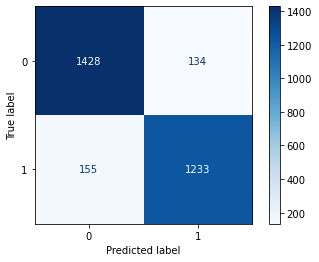

In [10]:
start_pipeline('cv', 'Mnb', 'Blues', pipe_params = {
                                'cv__max_features': [2_000, 4_500, 5_000, 5_500],
                                'cv__min_df' : [2,3], # ignore terms that show up less than 2 or 3 times in corpus
                                'cv__max_df' : [.5, .95], # ignore terms that show up either more than 50% or 95% of the corpus
                                'cv__ngram_range' : [(1,1), (1,2), (1,3)], # single words and bigrams
})

Score is pretty good, but slightly overfit. Increasing the max_features kept giving the best_estimator but the train/test score drifted further apart.
<br>Not bad on the confusion matrix, the model predicted 1428 of the posts as true positives and 1233 as true negatives (posts accurately predicted to their subreddits) with 289 total being misclassified.</br>

#### Deeper Dive into CountVectorizer
Now I am going to put the best params from the GridSearch back into the model to get deeper insight into the predictions

In [11]:
cv = CountVectorizer(max_df=0.95, max_features=5500, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words= stop_words)  ## all params from gridsearch

In [12]:
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [13]:
nb = MultinomialNB() #instantiating the model
nb.fit(X_train_cv, y_train);

In [14]:
preds = nb.predict(X_test_cv)
print(f"{(precision_score(y_test, preds))*100:.2f}% of the words were predicted correctly by the model.")


90.20% of the words were predicted correctly by the model.


#### Feature Importance Function & Chart

I want to check what the top 15 words were that help the model predict its class for each of the subreddits, and determine if there are any additional words that I need to add to the stopwords that make this model too depended on those words for prediction

In [15]:
def word_importance(model, vect, num):
    ami_prob_sorted = model.feature_log_prob_[1, :].argsort()[::-1] # getting the log probability of the feature [::-1] gives top features
    justno_prob_sorted = model.feature_log_prob_[0, :].argsort()[::-1]

    ami = np.take(vect.get_feature_names(), ami_prob_sorted[:num])
    justno = np.take(vect.get_feature_names(), justno_prob_sorted[:num]) # takes element from array, along axis, returns with feature_name

#Code addapted from:    
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes/50530697#50530697
#user piman314    

    print(f' Words in common in both classes : {np.intersect1d(ami, justno)}') #print a list where both words are in both arrays
    print('')
    
    ami_feat = pd.DataFrame((list(zip(ami, ami_prob_sorted))),columns = ['Features', 'Importance'])
    justno_feat = pd.DataFrame((list(zip(justno, justno_prob_sorted))),columns = ['Features', 'Importance'])
    
    ### Graph of AmITheAsshole Feature Importance

    
    ami_feat.set_index(ami_feat.Features, inplace=True) # so y label shows right

    ami_unit = ami_feat[:num].sort_values('Importance', ascending=False)['Importance'] # sort by coefficient show top 5
    color = ['#DF6120' if i > 5000 else "#40668C" for i in ami_unit]

    labels = ami_unit.index #only labels of selected

    plt.figure(figsize=(25,12))
    plt.barh(labels, ami_unit, color = color)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Feature Importance', fontsize=30)
    plt.title(f'Top {num} Predictable words to AmITheAsshole', fontsize=42, color ='#FF4500', weight='bold')
    if vect == cv:
        plt.savefig(f'./visuals/ami_pred_words_cv.png', transparent=True, bbox_inches='tight')
    else:    
        plt.savefig(f'./visuals/ami_pred_words_tfid.png', transparent=True, bbox_inches='tight')

    
    ### Graph of JustNOMIL Feature Importance

    justno_feat.set_index(justno_feat.Features, inplace=True) # so y label shows right

    justno_unit = justno_feat[:num].sort_values('Importance', ascending=False)['Importance'] # sort by coefficient show top 5
    color = ['#DF6120' if i > 5000 else "#40668C" for i in ami_unit]

    labels = justno_unit.index #only labels of selected

    plt.figure(figsize=(25,12))
    plt.barh(labels, justno_unit, color = color)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Feature Importance', fontsize=30)
    plt.title(f'Top {num} Predictable words to JustNOMIL', fontsize=42, color ='#FF4500', weight='bold')
    if vect == cv:
        plt.savefig('./visuals/justno_pred_words_cv.png', transparent=True, bbox_inches='tight')
    else:    
        plt.savefig('./visuals/justno_pred_words_tfid.png', transparent=True, bbox_inches='tight')

 

<a id = 'feat1'></a>

 Words in common in both classes : ['day' 'did' 'feel' 'going' 'home' 'house' 'things' 'think' 'years']



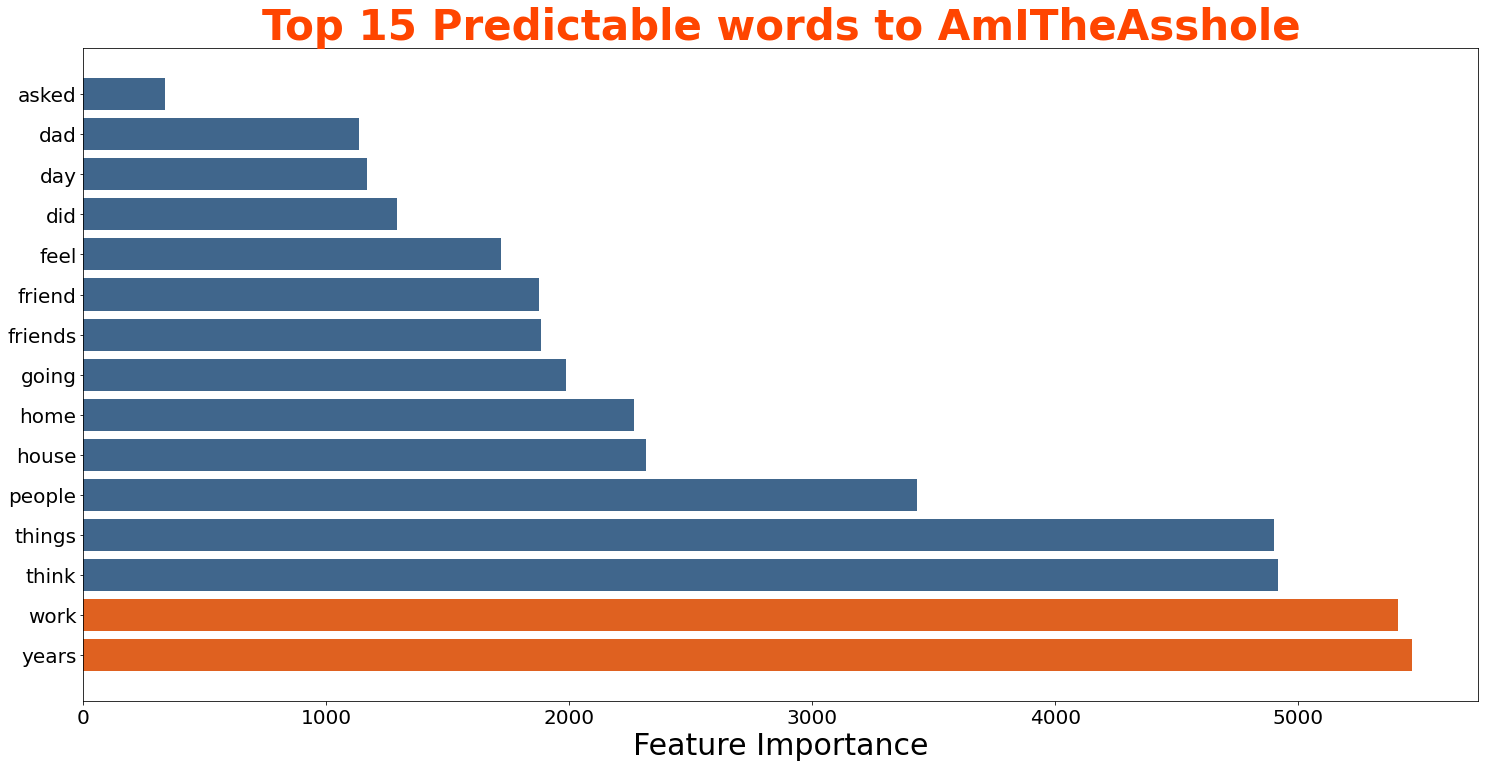

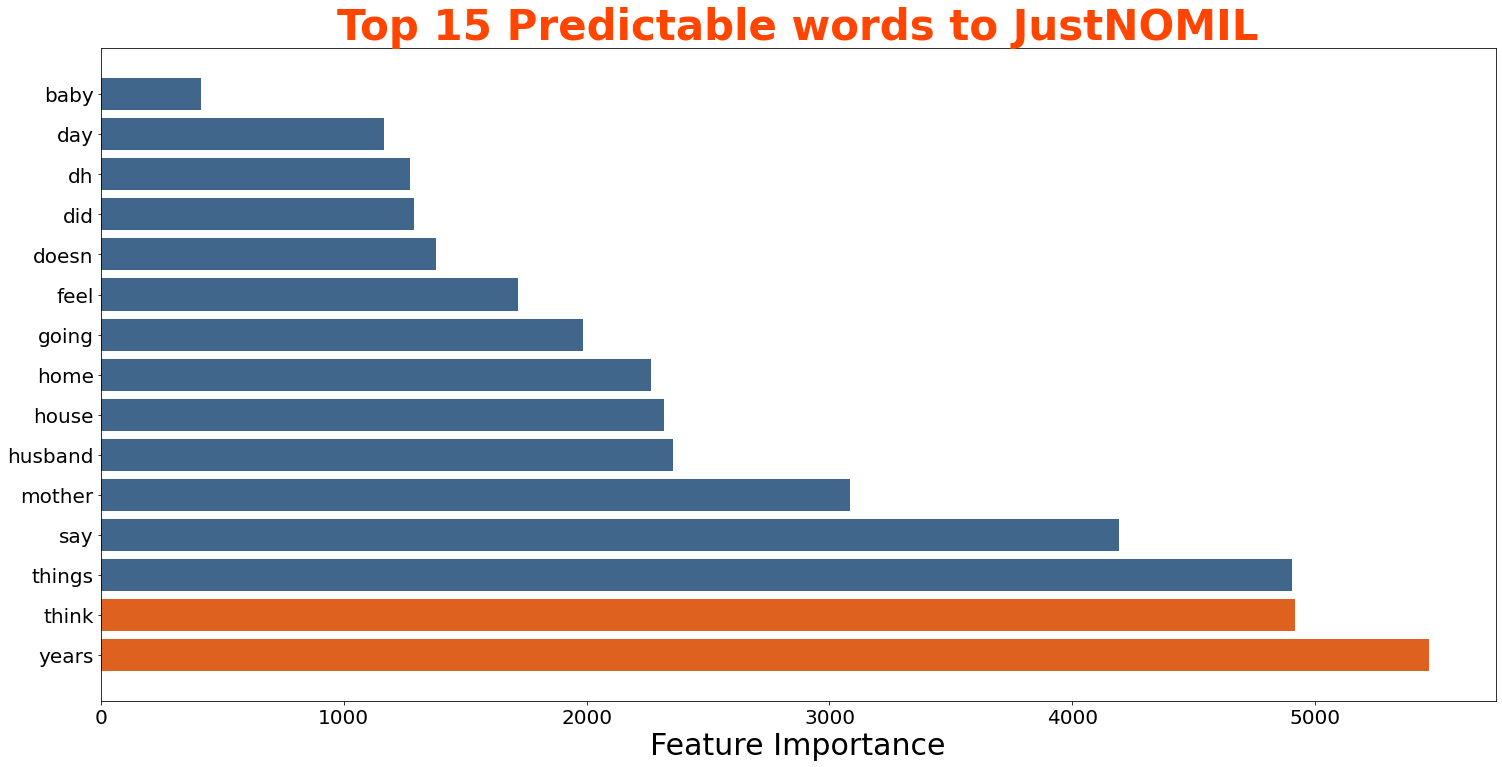

In [16]:
word_importance(nb, cv, 15)

<a id='Mtfid'></a>
### MultinomialNB w. TFIDF Vectorizer
I'll do the same as above to find the best hyperparameters for TFID. This will help me identify words that occur most in one subreddit more than the other.

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.6min finished


Gridsearch best score is: 0.8999889496763149

Gridsearch best params are: {'tvec__max_df': 0.5, 'tvec__max_features': 6000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}

MultinomialNB with TfidfVectorizer Train Score :  92.54%
MultinomialNB with TfidfVectorizer  Test Score  :  89.15%

MultinomialNB with TfidfVectorizer  F1- Train Score is 0.9205967276227142
MultinomialNB with TfidfVectorizer  F1- Test Score is F1-Score is 0.8823529411764706

90.09% of the words were predicted correctly by the model.
The specificity is: 91.55%


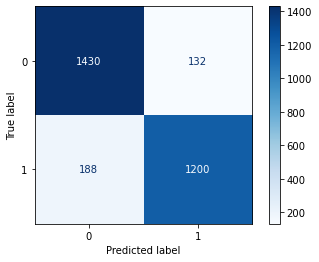

In [17]:
start_pipeline('tvec', 'Mnb', 'Blues', pipe_params = {
                                                        'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                        'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                        'tvec__min_df' : [2,3], 
                                                        'tvec__max_df' : [.5, .95]})

Score is further apart than our Count Vectorized Naive Bayes model
<br>Despite the train test score overfitting, this model predicts 91% accuracy to correct classify the subreddits</br>
<br>Again pretty good, predicting true negatives and true positives, with only 320 misclassified of the 2950</br>

#### Deeper Dive into CountVectorizer
Once again I will feed the search params back into the model for a closer look

In [18]:
tfid = TfidfVectorizer(max_df=0.95, max_features=6000, min_df=2,
                                 ngram_range=(1, 3),
                                 stop_words= stop_words)

X_train_tfid = tfid.fit_transform(X_train)
X_test_tfid = tfid.transform(X_test)

nb2 = MultinomialNB()
nb2.fit(X_train_tfid, y_train);


<a id= 'feat2' > </a>

 Words in common in both classes : ['day' 'did' 'going' 'house' 'parents']



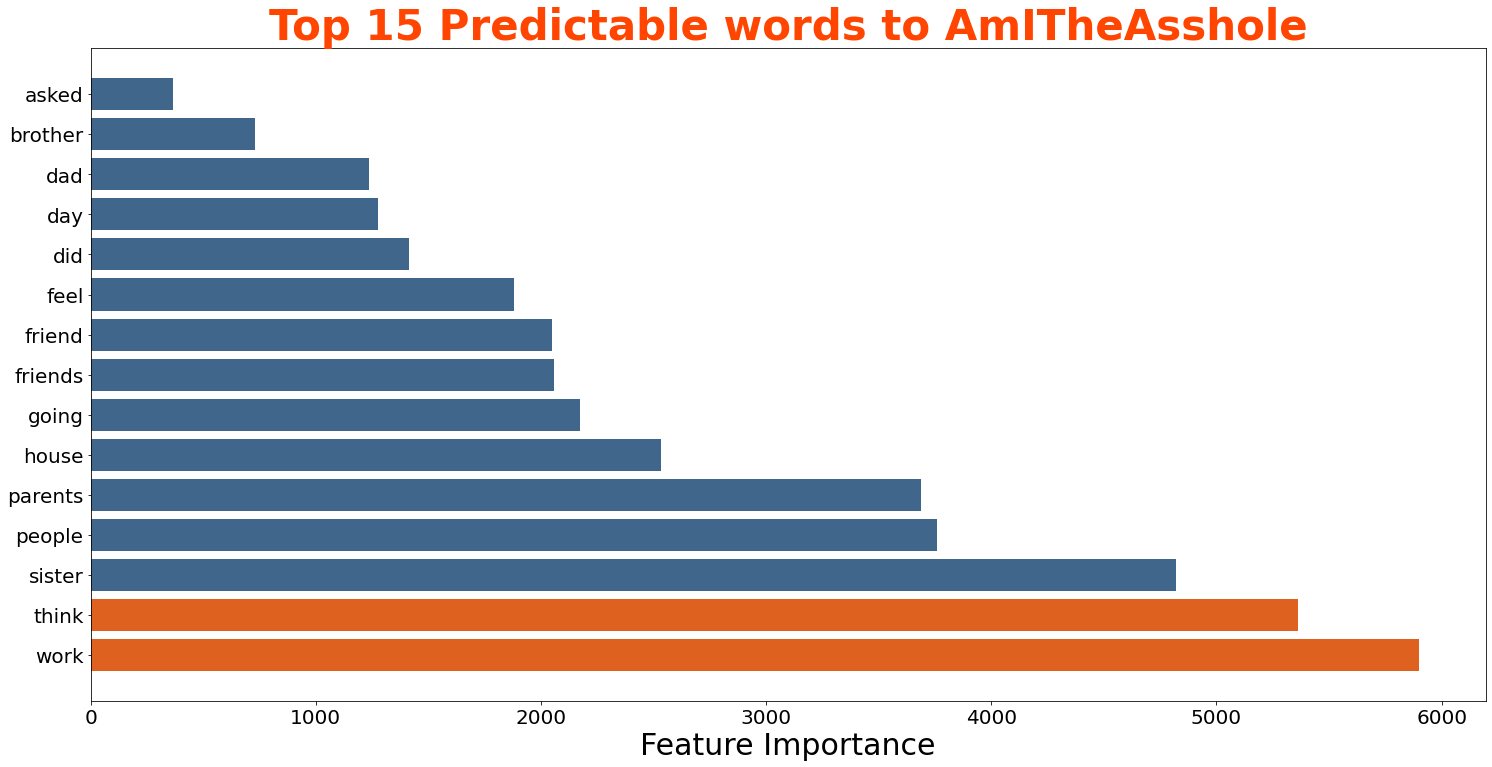

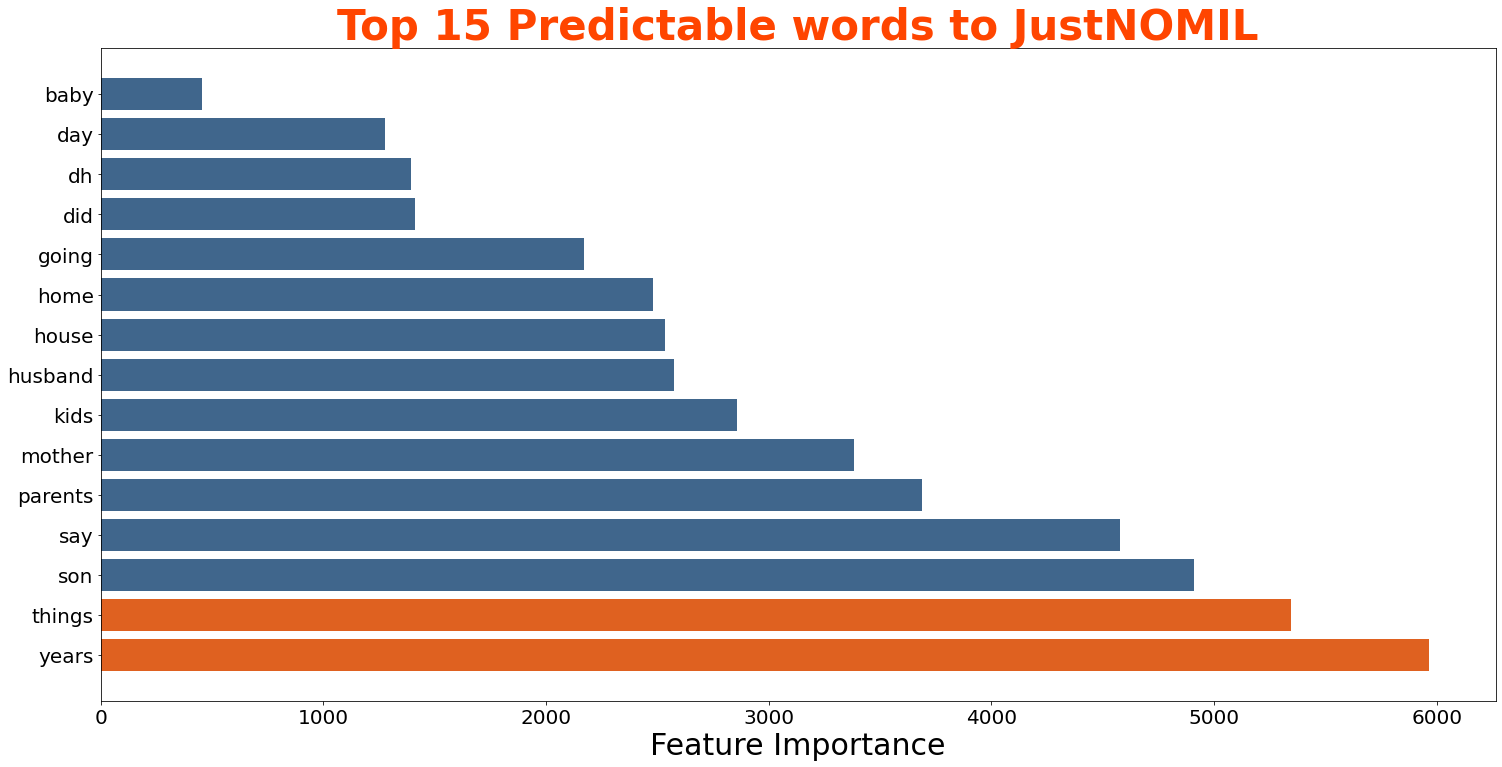

In [19]:
word_importance(nb2, tfid, 15)

<a id='Bcount'></a>
### BernoulliNB w. CountVectorizer

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 13.1min finished


Gridsearch best score is: 0.7920670173387883

Gridsearch best params are: {'Bnb__alpha': 0.2, 'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 2, 'cv__ngram_range': (1, 3)}

BernoulliNB with CountVectorizer Train Score :  80.96%
BernoulliNB with CountVectorizer  Test Score  :  80.20%

BernoulliNB with CountVectorizer  F1- Train Score is 0.8188366842275024
BernoulliNB with CountVectorizer  F1- Test Score is F1-Score is 0.8080210387902697

74.30% of the words were predicted correctly by the model.
The specificity is: 72.79%


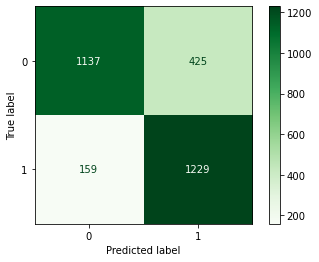

In [20]:
start_pipeline('cv', 'Bnb', 'Greens', pipe_params = {
                                                    'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                    'cv__max_features': [5_000, 5_500, 7_000, 9_000],
                                                    'cv__min_df' : [2,3],
                                                    'cv__max_df' : [.5, .95],
                                                    'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

The scores are closer to eachother, but at 80% rather than 90. Additionally there are 584 misclassified words, where only 74% of the words were predicted correctly

<a id='Btfid'></a>
### BernoulliNB w. TFIDF Vectorizer

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 13.1min finished


Gridsearch best score is: 0.7877726571557233

Gridsearch best params are: {'Bnb__alpha': 0.2, 'tvec__max_df': 0.5, 'tvec__max_features': 7000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}

BernoulliNB with TfidfVectorizer Train Score :  80.43%
BernoulliNB with TfidfVectorizer  Test Score  :  79.59%

BernoulliNB with TfidfVectorizer  F1- Train Score is 0.8136432106735528
BernoulliNB with TfidfVectorizer  F1- Test Score is F1-Score is 0.8014511873350924

73.91% of the words were predicted correctly by the model.
The specificity is: 72.54%


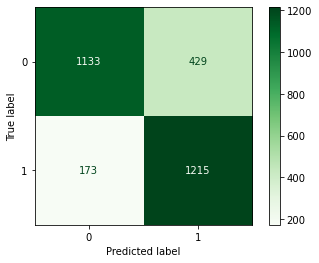

In [21]:
start_pipeline('tvec', 'Bnb', 'Greens', pipe_params = {
                                                'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                'tvec__min_df' : [2,3], 
                                                'tvec__max_df' : [.5, .95],
})

602 words were misclassified

<a id='conc'> </a>
### Conclusion:
changing some predictors to '*ref*' helped the model score better than completely removing them. Of the 4 model tries within the Naive Bayes estimators and Vectorizer transformers:
    - MultinomialNB with CountVectorizer performed the best and had the least amount of misclassified words. 
    - BernouilliNB had the least overfit model but it's prediction accuracy was only 74% with the most misclassified words
    
It's time to continue this adventure in my next notebook